In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D, AveragePooling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2669568007206985891
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6602251960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4791301743438697240
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None, multichannel=False):
    return compare_ssim(img1, img2, data_range=_range, multichannel=multichannel)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
"""
    resNet50 model
    
    https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
    https://keras.io/applications/#resnet
"""
import os
import warnings
from keras import layers as Layers
from keras import models as Models
from keras import utils as Utils
from keras_applications import imagenet_utils as utils

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

def get_submodules_from_kwargs(kwargs):
    backend = keras_backend
    layers = Layers
    models = Models
    utils = Utils
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape =  utils._obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='resnet50')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [3]:





"""
    resNet50 model
    loading weight 
"""
import os
import warnings
from keras import layers as Layers
from keras import models as Models
from keras import utils as Utils
from keras_applications import imagenet_utils as utils

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

def get_submodules_from_kwargs(kwargs):
    backend = keras_backend
    layers = Layers
    models = Models
    utils = Utils
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape =  utils._obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='resnet50')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path,  by_name=True)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [10]:
"""
    custom loss function
"""
"""
def customLoss(layer):
    def loss(y_true, y_pred):
        return keras_backend
    return loss
"""
# Keras lib: https://github.com/keras-team/keras-contrib
# Combine loss: https://stackoverflow.com/questions/51705464/keras-tensorflow-combined-loss-function-for-single-output
# TF example: https://stackoverflow.com/questions/52798540/working-with-ssim-loss-function-in-tensorflow-for-rgb-images
# MSE source: https://github.com/keras-team/keras/blob/master/keras/losses.py
# TF SSIM: https://www.tensorflow.org/api_docs/python/tf/image/ssim
#To-Notice: SSIM on RGB will be average

# Customize loss for multi parameters: https://github.com/keras-team/keras/issues/2121

# keras github mse problem for customize loss layer ( axis=-1)
#https://stackoverflow.com/questions/41707621/keras-mean-squared-error-loss-layer

#tensorflow mse
#https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error

#https://stackoverflow.com/questions/50124158/keras-loss-function-with-additional-dynamic-parameter
"""
https://www.mathworks.com/matlabcentral/answers/231932-is-this-how-to-calculate-mean-square-error-for-two-images
function MSE= MSE(lena, image_new);
[M, N] = size(lena);
error = lena - (image_new);
MSE = sum(sum(error .* error)) / (M * N);
disp(MSE);
end
"""

import keras.backend as K

def testMSE(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def MSE_Plus_SSIM(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1) + DSSIMObjective(y_true, y_pred)
    return (1.0 - tf.image.ssim(y_pred, y_true, 1.0)) + K.mean(K.square(y_pred - y_true))

def MSE_Plus_SSIM_Loss(y_true, y_pred, y_true_32, y_true_64, y_true_128, y_true_256, y_pred_32, y_pred_64, y_pred_128, y_pred_256): 
    loss = (
        (1.0 - tf.image.ssim(y_pred, y_true, 1.0))
        + (1.0 - tf.image.ssim(y_pred_32, y_true_32, 1.0))
        + (1.0 - tf.image.ssim(y_pred_64, y_true_64, 1.0))
        + (1.0 - tf.image.ssim(y_pred_128, y_true_128, 1.0))
        + (1.0 - tf.image.ssim(y_pred_256, y_true_256, 1.0))
    )
    
    loss2 = (
        K.mean(K.square(y_pred - y_true))
        + K.mean(K.square(y_pred_32 - y_true_32))
        + K.mean(K.square(y_pred_64 - y_true_64))
        + K.mean(K.square(y_pred_128 - y_true_128))
        + K.mean(K.square(y_pred_256 - y_true_256))
    )
    
    """
    loss = (
        (1.0 - tf.image.ssim(y_pred, y_true, 1.0)) + K.mean(K.square(y_pred - y_true), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_16, y_true_16, 1.0)) + K.mean(K.square(y_pred_16 - y_true_16), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_32, y_true_32, 1.0)) + K.mean(K.square(y_pred_32 - y_true_32), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_64, y_true_64, 1.0)) + K.mean(K.square(y_pred_64 - y_true_64), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_128, y_true_128, 1.0)) + K.mean(K.square(y_pred_128 - y_true_128), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_256, y_true_256, 1.0)) + K.mean(K.square(y_pred_256 - y_true_256), axis=-1)
    )"""
    return loss + loss2

In [5]:
model = ResNet50(input_shape=(512,512, 3), include_top=False)
model.trainable = False

"""
model.compile(loss=MSE_Plus_SSIM,
                  optimizer=Adam(),
                  metrics=['accuracy'])
"""
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\tomsan\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:244: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
"""
    resNet as backbone with simple CNN model
"""
def resNet50asBackbone(pretrained_weights=None):
    x_input = Input(shape=(512, 512, 3), name='image_in')
    
    y_true = Input( shape=(512, 512, 3), name='y_true' ) # 4000 * 0.7
    
    # MaxPooling2D, AveragePooling2D, cv2.resize
    y_true_256 = MaxPooling2D(pool_size=(2, 2))(y_true)
    y_true_128 = MaxPooling2D(pool_size=(2, 2))(y_true_256)
    y_true_64 = MaxPooling2D(pool_size=(2, 2))(y_true_128)
    y_true_32 = MaxPooling2D(pool_size=(2, 2))(y_true_64)
    
    x_pool_256 = MaxPooling2D(pool_size=(2, 2))(x_input)
    x_pool_128 = MaxPooling2D(pool_size=(2, 2))(x_pool_256)
    x_pool_64 = MaxPooling2D(pool_size=(2, 2))(x_pool_128)
    x_pool_32 = MaxPooling2D(pool_size=(2, 2))(x_pool_64)
    
    x_32 = model(x_input) #32 64 128 256 512
    x_32 = Conv2D(1024, (3, 3), activation='relu',padding="same")(x_32)
    x_32 = Conv2D(1024, (3, 3), activation='relu',padding="same")(x_32)
    
    x_64 = UpSampling2D(interpolation="bilinear")(x_32)
    x_64 = Conv2D(512, (3, 3), activation='relu',padding="same")(x_64)
    x_64 = Conv2D(512, (3, 3), activation='relu',padding="same")(x_64)
    
    x_128 = UpSampling2D(interpolation="bilinear")(x_64)
    x_128 = Conv2D(256, (3, 3), activation='relu',padding="same")(x_128)
    x_128 = Conv2D(256, (3, 3), activation='relu',padding="same")(x_128)
    
    x_256 = UpSampling2D(interpolation="bilinear")(x_128)
    x_256 = Conv2D(128, (3, 3), activation='relu',padding="same")(x_256)
    x_256 = Conv2D(128, (3, 3), activation='relu',padding="same")(x_256)
    
    x_512 = UpSampling2D(interpolation="bilinear")(x_256)
    
    
    y_pred_32 = Conv2D(3, (1, 1), padding="same")(x_32)
    y_pred_32 = Add()([y_pred_32, x_pool_32])
    y_pred_64 = Conv2D(3, (1, 1), padding="same")(x_64)
    y_pred_64 = Add()([y_pred_64, x_pool_64])
    y_pred_128 = Conv2D(3, (1, 1), padding="same")(x_128)
    y_pred_128 = Add()([y_pred_128, x_pool_128])
    y_pred_256 = Conv2D(3, (1, 1), padding="same")(x_256)
    y_pred_256 = Add()([y_pred_256, x_pool_256])
    y_pred_512 = Conv2D(3, (1, 1), padding="same")(x_512)
    y_pred = Add()([x_input, y_pred_512])
    """
    resNet50model = Model(inputs=x_input, outputs=y_pred)
    """
    #https://stackoverflow.com/questions/50124158/keras-loss-function-with-additional-dynamic-parameter
    resNet50model = Model( inputs=[x_input, y_true], outputs=y_pred, name='train_only' )
    resNet50model.add_loss( MSE_Plus_SSIM_Loss(y_true, y_pred, y_true_32, y_true_64, y_true_128, y_true_256, y_pred_32, y_pred_64, y_pred_128, y_pred_256) )
    resNet50model.compile(loss=None,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    if(pretrained_weights):
        resNet50model.load_weights(pretrained_weights)
    return resNet50model

In [12]:
resNet50 = resNet50asBackbone()
print(resNet50.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 32, 32, 1024) 8589184     image_in[0][0]                   
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 1024) 9438208     resnet50[3][0]                   
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 1024) 9438208     conv2d_23[0][0]                  
__________________________________________________________________________________________________
up_samplin

In [23]:




"""
    origin loss 
"""
def sampleModel(pretrained_weights=None):
    x_input = Input(shape=(512, 512, 3), name='image_in')
    
    y_true = Input( shape=(512, 512, 3), name='y_true' ) # 4000 * 0.7
    
    
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x_input)
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x)
    y_pred = Conv2D(3, (1, 1), activation='relu',padding="same", name='y_pred')(x)
    
    """
    resNet50model = Model(inputs=x_input, outputs=y_pred)
    """
    #https://stackoverflow.com/questions/50124158/keras-loss-function-with-additional-dynamic-parameter
    resNet50model = Model( inputs=[x_input, y_true], outputs=y_pred, name='train_only' )
    resNet50model.add_loss( testMSE(y_true, y_pred) )
    resNet50model.compile(loss=None,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    if(pretrained_weights):
        resNet50model.load_weights(pretrained_weights)
    return resNet50model

sModel = sampleModel()
print(sModel.summary())















_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_in (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 512, 512, 64)      1792      
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
y_pred (Conv2D)              (None, 512, 512, 3)       195       
Total params: 112,771
Trainable params: 112,771
Non-trainable params: 0
_________________________________________________________________
None

In [13]:
"""
    load training data
"""
import gc

dataY = np.zeros((4000,512, 512, 3))

count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + ".png")
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
                 
dataY = dataY.reshape(-1, 512, 512, 3)
dataY = dataY.astype('float32') / 255

In [14]:
"""
    noise image
"""
X = np.zeros((4000,512, 512, 3))
count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise50.png")
    X[count] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise60.png")
    X[count+1] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise70.png")
    X[count+2] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise80.png")
    X[count+3] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise90.png")
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 3)
X = X.astype('float32') / 255

#can not use validation_data due to multiple input
#X_train, X_test, y_train, y_test = train_test_split(X, dataY, test_size=0.3, random_state=41)

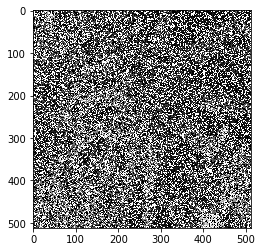

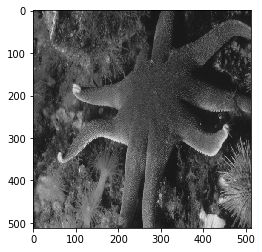

7.245694994926453


In [15]:
X_train = X.reshape(-1, 512, 512, 3)
y_train = dataY.reshape(-1, 512, 512, 3)
img = X_train[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], X_train[1]) )

In [23]:
modelCheck = ModelCheckpoint('backbone_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()

resNet50.fit([X, dataY],
            batch_size=1,
            epochs=200,
            verbose=1,
            validation_split=0.3,
            callbacks=[modelCheck, history])

Train on 2800 samples, validate on 1200 samples
Epoch 1/200
2800/2800 [==============================] - 370s 132ms/step - loss: 4.8032 - val_loss: 4.7895
Epoch 2/200
2800/2800 [==============================] - 376s 134ms/step - loss: 4.7835 - val_loss: 4.7624
Epoch 3/200
2800/2800 [==============================] - 362s 129ms/step - loss: 4.7795 - val_loss: 4.7611
Epoch 4/200
2800/2800 [==============================] - 374s 133ms/step - loss: 4.7772 - val_loss: 4.7621
Epoch 5/200
2800/2800 [==============================] - 363s 130ms/step - loss: 4.7762 - val_loss: 4.7608
Epoch 6/200
2800/2800 [==============================] - 358s 128ms/step - loss: 4.7762 - val_loss: 4.7610
Epoch 7/200
2800/2800 [==============================] - 368s 131ms/step - loss: 4.7761 - val_loss: 4.7612
Epoch 8/200
2800/2800 [==============================] - 380s 136ms/step - loss: 4.7765 - val_loss: 4.7607
Epoch 9/200
2800/2800 [==============================] - 375s 134ms/step - loss: 4.7760 - val_lo

2800/2800 [==============================] - 341s 122ms/step - loss: 4.7749 - val_loss: 4.7629
Epoch 152/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7748 - val_loss: 4.7607
Epoch 153/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7751 - val_loss: 4.7606
Epoch 154/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7751 - val_loss: 4.7615
Epoch 155/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7751 - val_loss: 4.7610
Epoch 156/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7751 - val_loss: 4.7607
Epoch 157/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7751 - val_loss: 4.7613
Epoch 158/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7752 - val_loss: 4.7632
Epoch 159/200
2800/2800 [==============================] - 341s 122ms/step - loss: 4.7751 - val_loss: 4.7611
Epoch 160/200
2800/2800 [========

In [24]:
modelCheck = ModelCheckpoint('backbone_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()

sModel.fit([X, dataY],
            batch_size=1,
            epochs=3,
            verbose=1,
            validation_split=0.3,
            callbacks=[modelCheck, history])

Train on 2800 samples, validate on 1200 samples
Epoch 1/3
2800/2800 [==============================] - 125s 45ms/step - loss: 0.0344 - val_loss: 0.0128
Epoch 2/3
2800/2800 [==============================] - 120s 43ms/step - loss: 0.0095 - val_loss: 0.0047
Epoch 3/3
2800/2800 [==============================] - 117s 42ms/step - loss: 0.0046 - val_loss: 0.0033


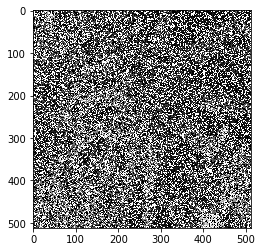

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


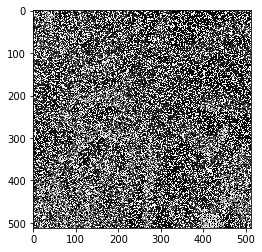

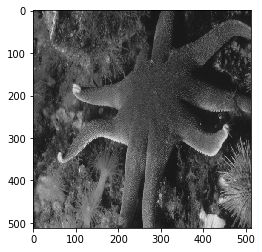

7.481186389923096
6.964301943778992
0.02250832169482374
0.015261080326002693


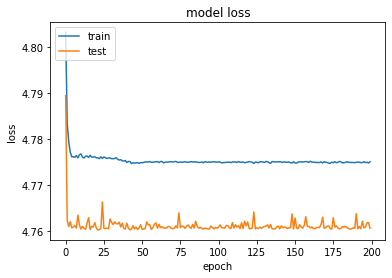

In [24]:
"""
print("== SRCNN accuracy ==")
score = resNet50.evaluate([X, dataY], verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
"""
result = resNet50.predict([X[:10], dataY[:10]])
X_train = X
y_train = dataY
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], result[1]) )

totalPSNR = 0
for i in range(10):
    totalPSNR += PSNR(y_train[i], result[i])
#print(totalPSNR)
print(totalPSNR / 10)

totalSSIM = 0
for i in range(10):
    totalSSIM += SSIM(y_train[i], result[i], 1.0, multichannel=True)
#print(totalSSIM)
print(SSIM(y_train[1], result[1], 1.0, multichannel=True))
print(totalSSIM / 10)

# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()